# Lab 8: Exercise solutions

In [1]:
with open('../course/common.py') as fin:
    exec(fin.read())

In [2]:
with open('../course/matplotlibconf.py') as fin:
    exec(fin.read())

## Exercise 1

For our Spam detection model, we used a `CountVectorizer` with a vocabulary size of 3000. Was this the best size? Let's find out:

- reload the spam dataset
- do a train test split with `random_state=0` on the SMS data frame
- write a function `train_for_vocab_size` that takes `vocab_size` as input and does the following:
    - initialize a `CountVectorizer` with `max_features=vocab_size`
    - fit the vectorizer on the training messages
    - transform both the training and the test messages to count matrices
    - train the model on the training set
    - return the model accuracy on the training and test set
- plot the behavior of the train and test set accuracies as a function of `vocab_size` for a range of different vocab sizes

Let's reload the sms data we have previously saved:

In [3]:
df = pd.read_csv('../data/sms_spam.csv')
df.head()

,message,spam
0,Hi Princess! Thank you for...,0
1,Hello my little party anim...,0
2,And miss vday the parachut...,0
3,Maybe you should find some...,0
4,What year. And how many mi...,0


Train/Test split on the messages, notice that we use Numpy Arrays, not Pandas Dataframes:

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
docs_train, docs_test, y_train, y_test = \
    train_test_split(df['message'].values,
                     df['spam'].values,
                     random_state=0)

Now let's write the function:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [7]:
def train_for_vocab_size(vocab_size):
    vect = CountVectorizer(decode_error='ignore',
                           stop_words='english',
                           max_features=vocab_size)

    vect.fit(docs_train)
    X_train_sparse = vect.transform(docs_train)
    X_train = X_train_sparse.todense()
    
    X_test_sparse = vect.transform(docs_test)
    X_test = X_test_sparse.todense()
    
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(1, input_dim=input_dim, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=20, verbose=0)
    
    train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
    test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return input_dim, train_acc, test_acc

Now let's try a few vocab_sizes with increasing separation:

In [8]:
sizes = [2, 3, 5, 10, 30, 50, 100, 300, \
         500, 1000, 3000, 5000, 10000]
idx = []
train_accs = []
test_accs = []

for v in sizes:
    i, tra, tea = train_for_vocab_size(v)

    idx.append(i)
    train_accs.append(tra)
    test_accs.append(tea)
    
    print("Done vocab size: ", i)

Done vocab size:  2
Done vocab size:  3
Done vocab size:  5
Done vocab size:  10
Done vocab size:  30
Done vocab size:  50
Done vocab size:  100
Done vocab size:  300
Done vocab size:  500
Done vocab size:  1000
Done vocab size:  3000
Done vocab size:  5000
Done vocab size:  7150


Let's organize the results in a DataFrame

In [9]:
resdf = pd.DataFrame(train_accs,
                     columns=['Train'],
                     index=idx)

resdf['Test'] = test_accs

and let's plot the results using the logarithmic scale for the x axis. Remember that our benchmark accuracy is 86.6%, so we will add a baseline at that level:

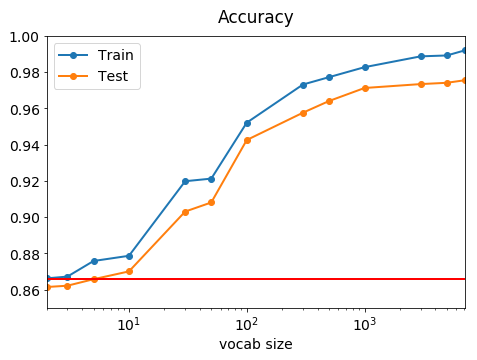

In [10]:
resdf.plot(logx=True, style='-o', title='Accuracy')
plt.xlabel('vocab size')
plt.ylim(0.85, 1)
plt.axhline(0.866, color='red');

## Exercise 2

Keras provides a large dataset of movie reviews extracted from the [Internet Movie Database](www.imdb.com) for sentiment analysis purposes. This dataset is much larger than the one we have used, and its already encoded as sequences of integers. Let's put what we have learned to good use and build a sentiment classifier for movie reviews:

- decide what size of vocabulary you are going to use and set the `vocab_size` variable
- import the `imdb` module from `keras.datasets`
- load the train and test sets using `num_words=vocab_size`
- check the data you have just loaded; they should be sequences of integers
- pad the sequences to a fixed length of your choice. You will need to:
    - decide what a reasonable length to express a movie review is
    - decide if you are going to truncate the beginning or the end of reviews that are longer than such length
    - decide if you are going to pad with zeros at the beginning or the end for reviews that are shorter than such length
- build a model to do sentiment analysis on the truncated sequences
- train the model on the training set
- evaluate the performance of the model on the test set

Bonus points: can you convert back the sentences to their original text form? You should look at `imdb.get_word_index()` to download the word index:

In [11]:
vocab_size=20000

In [12]:
from tensorflow.keras.datasets import imdb

In [13]:
(X_train, y_train), (X_test, y_test) = \
    imdb.load_data(num_words=vocab_size)

In [14]:
X_train.shape

(25000,)

In [15]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

Let's use a maximum review length of 80 words. This seems long enough to express an opinion about the movie:

In [16]:
maxlen = 80

We will pad sequences using the default `padding='pre'` and `truncating='pre'` parameters.

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

Let's build the model:

In [19]:
embedding_size = 100

In [20]:
from tensorflow.keras.layers import LSTM, Embedding

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

> TIP: in the above model we have used `dropout`, which has not yet been formally introduced. For now just know that it's a technique aimed at reducing overfitting.

In [22]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,042,305
Trainable params: 2,042,305
Non-trainable params: 0
_________________________________________________________________


Let's train the model for a couple of epochs. If you run this model on your laptop it may take a few minutes for each epoch:

In [23]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3);

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 7s 405us/sample - loss: 0.4623 - accuracy: 0.7750 - val_loss: 0.3731 - val_accuracy: 0.8352
Epoch 2/2
17500/17500 [==============================] - 6s 317us/sample - loss: 0.2528 - accuracy: 0.9002 - val_loss: 0.3911 - val_accuracy: 0.8284


And let's evaluate the training and test accuracies

In [24]:
train_loss, train_acc = model.evaluate(X_train_pad, y_train)

print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

25000/25000 [==============================] - 2s 89us/sample - loss: 0.2349 - accuracy: 0.9164
Train loss: 0.23490027963638305
Train accuracy: 0.91636


In [25]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 2s 90us/sample - loss: 0.3966 - accuracy: 0.8257
Test loss: 0.39658818774223326
Test accuracy: 0.82572


Not bad! We have a sentiment analysis model that we can unleash on the social media of our choice. Time to go to an investor and raise money! Not quite, but it's nice to see how easy it has become to build a model that would have been unthinkable just a few years ago.

Finally, for the bonus question. Let's get the word index:

In [26]:
idx = imdb.get_word_index()

and let's create the reverse index. Notice that the documentation of `imdb.load_data` reads:

```python
"""
Signature: imdb.load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs)
Docstring:
Loads the IMDB dataset.

# Arguments
    path: where to cache the data (relative to `~/.keras/dataset`).
    num_words: max number of words to include. Words are ranked
        by how often they occur (in the training set) and only
        the most frequent words are kept
    skip_top: skip the top N most frequently occurring words
        (which may not be informative).
    maxlen: truncate sequences after this length.
    seed: random seed for sample shuffling.
    start_char: The start of a sequence will be marked with this character.
        Set to 1 because 0 is usually the padding character.
    oov_char: words that were cut out because of the `num_words`
        or `skip_top` limit will be replaced with this character.
    index_from: index actual words with this index and higher.

# Returns
    Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
"""
```
so we will need to shift all indices by three to recover meaningful sentences:

In [27]:
rev_idx = {v+3:k for k,v in idx.items()}

Also, following the documentation let's add the start character and the out-of-vocabulary character:

In [28]:
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'

We can then apply the reverse index to recover the text of a review:

In [29]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert oov_char is an amazing actor and now the same being director oov_char father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the oov_char of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing an

Great! These are indeed movie reviews.